# Задание

В этом задании необходимо применить нейронную сеть UNet. Необходимо решать задачу сегментации дерматологические поражения, проще
говоря родинок, родимых пятен и.т. д. В датасете присутствуют фотографии
родинок и соответствующие бинарные маски.

Использовать датасет ISIC 3B доступный по https://challenge.isic-archive.com/data/. Прямая ссылка на train https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Training_Data.zip , ссылка на test https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Test_Data.zip(данные занимают около 800мб).
Подготовить эти данные для тренировки, подобрать оптимизатор и его гиперпараметры, обучить вашу модель на тренировочных данных и также
оцените качество работы этой модели на тестовой выборке.


# Предварительная стратегия решения решения задания:
- модифицировать блоки UNetBlock и UNetUpBlock таким образом,
чтобы padding был равен 1. Это позволит сохранить размеры
изображения.
- Изменить последний сверточный слой модели UNet, чтобы он
возвращал 1 слойный тензор.
- для ускорения расчетов, предлагаю сжимать входные изображения до
размера 256*256.
- поделить тренировочную выборку на train/val. Test используйте отдельно
- тренировка занимает продолжительное время, использовать GPU если
она есть или GoogleColab.
- для оценки модели потребуется модифицировать функцию
вычисления IoU так, чтобы она предварительно преобразовывала
входные изображения в бинарные маски по определенному порогу.
- Экспериментировать с гипер параметрами модели,
оптимизаторами, числом эпох.


In [ ]:
import torch
import os  # Работа с файлами и папками
from torch.utils.data import DataLoader, Dataset, random_split
# DataLoader — создает батчи данных для обучения, Dataset — описывает набор данных, random_split — случайный разбиение данных на части
import torchvision.transforms as transforms
# torchvision.transforms — для преобразования изображений (например, изменение размера, преобразование в тензор)
from PIL import Image  # Для открытия и обработки изображений
from tqdm import tqdm  # Прогресс-бар для отображения прогресса цикла
import matplotlib.pyplot as plt  # Для визуализации изображений
import torch.nn as nn  # Модули нейронных сетей
import torch.optim as optim  # Оптимизаторы для обучения сети
import numpy as np

In [ ]:
# Подключение к GPU в Google Colab (обычно Colab сам выбирает устройство)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.device выбирает устройство для вычислений: "cuda" (GPU) если доступен, иначе "cpu" (процессор)
print("Using device:", device)  # Выводим, какое устройство используется (GPU или CPU)

Using device: cuda


In [ ]:
# Скачиваем и распаковываем данные прямо в Colab
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Training_Data.zip -O train_data.zip
# wget скачивает архив с тренировочными данными по ссылке и сохраняет его под именем train_data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Test_Data.zip -O test_data.zip
# Аналогично скачиваем тестовые данные
!unzip -q train_data.zip -d train_data
# unzip распаковывает архив train_data.zip в папку train_data (-q — тихий режим без вывода)
!unzip -q test_data.zip -d test_data
# Распаковка тестовых данных

--2025-07-29 06:13:55--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.164.57, 3.5.28.144, 52.216.58.241, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.164.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637616892 (608M) [application/zip]
Saving to: ‘train_data.zip’

train_data.zip      100%[===================>] 608.08M  16.6MB/s    in 40s     

2025-07-29 06:14:36 (15.2 MB/s) - ‘train_data.zip’ saved [637616892/637616892]

--2025-07-29 06:14:36--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3B_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 54.231.169.33, 16.15.176.200, 3.5.28.100, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|54.231.169.33

In [ ]:
batch_size = 8
# Количество изображений в одном пакете (батче), который передается в нейросеть за один проход

class CustomDataset(Dataset):
    # Класс, описывающий датасет с изображениями и масками сегментации
    def __init__(self, data_folder, transform=None):
        image_paths = []
        mask_paths = []
        for filename in os.listdir(data_folder):
            # Перебираем все файлы в папке data_folder
            if filename.endswith(".jpg"):
                # Если файл — изображение с расширением jpg
                base_name = os.path.splitext(filename)[0]
                # Получаем имя файла без расширения
                mask_filename = base_name + "_Segmentation.png"
                # Формируем имя файла с маской сегментации
                mask_path = os.path.join(data_folder, mask_filename)
                image_path = os.path.join(data_folder, filename)
                if os.path.exists(mask_path):
                    # Проверяем, что маска существует
                    image_paths.append(image_path)  # Добавляем путь к изображению
                    mask_paths.append(mask_path)    # Добавляем путь к маске
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform  # Преобразования, которые будут применены к изображениям и маскам

    def __len__(self):
        return len(self.image_paths)  # Общее количество элементов в датасете

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")
        # Открываем изображение по индексу и конвертируем в "L" — grayscale (черно-белое)
        mask = Image.open(self.mask_paths[idx]).convert("L")
        # Аналогично для маски
        if self.transform:
            image = self.transform(image)  # Применяем преобразования к изображению (например, resize, to tensor)
            mask = self.transform(mask)    # Применяем те же преобразования к маске
        return image, mask  # Возвращаем пару: изображение и соответствующую маску

# Модель сети Unet

In [ ]:
def crop_tensor_to_match(tensor, target_tensor):
    """
    Функция для обрезания тензора до размера, который должен быть в 2 раза больше размера target_tensor.
    Аргументы:
    - tensor: исходный тензор, который нужно обрезать.
    - target_tensor: тензор, по размеру которого мы ориентируемся.

    Задача: обрезать tensor так, чтобы его высота и ширина стали ровно в 2 раза больше, чем у target_tensor.

    Пояснение по размерам тензоров:
    - tensor.size() возвращает кортеж с размерами тензора в формате (batch_size, channels, height, width).
    - target_tensor.size() — аналогично, размеры целевого тензора.

    Переменные:
    - target_x = target_tensor.size()[3] * 2
      — ширина (axis 3) target_tensor, умноженная на 2.
    - target_y = target_tensor.size()[2] * 2
      — высота (axis 2) target_tensor, умноженная на 2.
    - diffY = tensor.size()[2] - target_y
      — разница между высотой исходного тензора и нужной высотой (в 2 раза больше целевого).
    - diffX = tensor.size()[3] - target_x
      — разница между шириной исходного тензора и нужной шириной.

    Обрезание:
    - Используем срезы по высоте и ширине:
      tensor[:, :, start_y:end_y, start_x:end_x]
      где start_y = diffY // 2 — сдвиг с верхнего края для центрирования обрезки,
      end_y = start_y + target_y — конечная точка по высоте,
      аналогично по ширине.

    Возвращаемый результат:
    - cropped_tensor — тензор, обрезанный по центру, с размерами (batch_size, channels, target_y, target_x),
      то есть в 2 раза больше, чем размеры target_tensor.
    """
    target_x = target_tensor.size()[3]*2  # вычисляем нужную ширину: в 2 раза больше, чем у target_tensor
    target_y = target_tensor.size()[2]*2  # вычисляем нужную высоту: в 2 раза больше, чем у target_tensor
    diffY = tensor.size()[2] - target_y   # на сколько исходный тензор больше по высоте
    diffX = tensor.size()[3] - target_x   # на сколько исходный тензор больше по ширине
    # обрезаем тензор по центру, сдвигаясь на половину излишка сверху и слева
    cropped_tensor = tensor[:, :, diffY // 2: diffY // 2 + target_y, diffX // 2: diffX // 2 + target_x]
    return cropped_tensor  # возвращаем обрезанный тензор



class UNetBlock(nn.Module):  # Определяем блок U-Net, наследуем от nn.Module (базовый класс нейросетей в PyTorch)
    def __init__(self, in_channels, out_channels):
        super(UNetBlock, self).__init__()  # Инициализация базового класса

        # Первый сверточный слой:
        # in_channels — число входных каналов (например, 3 для RGB),
        # out_channels — число выходных каналов (фильтров),
        # kernel_size=3 — размер фильтра 3x3,
        # padding=1 — c добавлением пикселей на границе. Для сохранения рахмеров изображения.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(out_channels)
        # Создаём слой пакетной нормализации (Batch Normalization) для 2D данных (например, изображений)
        # out_channels — количество каналов (фильтров) на выходе сверточного слоя, для которых будет рассчитана нормализация

        # Что делает BatchNorm2d:
        # - Нормализует активации (выходы предыдущего слоя) по каждому каналу отдельно
        # - Вычисляет среднее и стандартное отклонение по батчу и пространственным измерениям (высота, ширина)
        # - Приводит значения к нулевому среднему и единичному отклонению, затем масштабирует и сдвигает их с помощью обучаемых параметров
        # - Помогает стабилизировать и ускорить обучение нейросети, снижая внутреннее смещение распределения активаций

        # Функция активации ReLU:
        # inplace=True — изменяет данные на месте без создания нового объекта (экономит память)
        self.relu = nn.ReLU(inplace=True)

        # Второй сверточный слой:
        # in_channels и out_channels равны out_channels первого слоя,
        # kernel_size и padding аналогичны первому,
        # каждый сверточный слой — отдельный слой с собственными весами
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.bn2 = nn.BatchNorm2d(out_channels)
        # Операция максимального объединения (max pooling):
        # kernel_size=2 — берет максимум из каждой области 2x2,
        # stride=2 — сдвигается на 2 пикселя, уменьшая размер изображения вдвое по ширине и высоте
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Прямой проход данных через блок

        x = self.conv1(x)  # Проходим через первую свертку
        x = self.bn1(x)   # Применяем слой нормализации
        x = self.relu(x)   # Применяем ReLU — обнуляем отрицательные значения
        x = self.conv2(x)  # Проходим через вторую свертку
        x = self.bn2(x)   # Применяем слой нормализации
        x = self.relu(x)   # Снова ReLU

        pooled = self.pool(x)  # Применяем max pooling, уменьшая размер

        # Возвращаем два значения:
        # x — результат после двух сверток (будет использоваться для пропуска (skip connection) в U-Net),
        # pooled — уменьшенная версия для следующего уровня сети
        return x, pooled


class UNetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetUpBlock, self).__init__()
        # nn.ConvTranspose2d - транспонированная свертка, используется для увеличения пространственных размеров (upsampling).
        # Параметры:
        # in_channels - количество входных каналов,
        # out_channels - количество выходных каналов,
        # kernel_size=2 - размер ядра свертки 2x2,
        # stride=2 - шаг 2 для удвоения размера входа (например, 64x64 -> 128x128).
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # nn.Conv2d - обычная 2D-свертка для извлечения признаков.
        # Параметры:
        # in_channels - количество входных каналов,
        # out_channels - количество выходных каналов,
        # kernel_size=3 - размер ядра 3x3,
        # padding=1 — c добавлением пикселей на границе. Для сохранения рахмеров изображения.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

        # Создаём слой пакетной нормализации (Batch Normalization) для 2D данных (например, изображений)
        self.bn1 = nn.BatchNorm2d(out_channels)


        # nn.ReLU - функция активации ReLU (Rectified Linear Unit),
        # inplace=True означает, что операция делается "на месте" для экономии памяти.
        self.relu = nn.ReLU(inplace=True)

        # Второй сверточный слой с теми же параметрами, для более глубокого извлечения признаков.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Создаём слой пакетной нормализации (Batch Normalization) для 2D данных (например, изображений)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, skip_connection):
        # x - входной тензор (например, из предыдущего слоя U-Net, с уменьшенным пространственным размером).
        # skip_connection - тензор из соответствующего слоя вниз по U-Net, для объединения деталей.

        # Применяем транспонированную свертку для увеличения размера изображения (upsampling).
        x = self.upconv(x)

        # Объединяем (конкатенируем) по канальному измерению (dim=1)
        # upsampled x и skip_connection, чтобы сохранить детали из ранних слоев.
        x = torch.cat([x, skip_connection], dim=1)

        # Пропускаем результат через первый сверточный слой для извлечения признаков.
        x = self.conv1(x)
        # Применяем слой нормализации
        x = self.bn1(x)
        # Применяем активацию ReLU для нелинейности.
        x = self.relu(x)

        # Пропускаем через второй сверточный слой для более детальной обработки.
        x = self.conv2(x)

        # Применяем слой нормализации
        x = self.bn1(x)

        # Снова ReLU активация.
        x = self.relu(x)

        # Возвращаем обработанный тензор.
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Инициализация блоков энкодера (сжатия)
        # Каждый блок уменьшает размерность, увеличивает число каналов
        self.enc1 = UNetBlock(1, 64)    # Вход 1 канал (например, grayscale), выход 64 канала
        self.enc2 = UNetBlock(64, 128)  # Принимает 64 канала, отдаёт 128
        self.enc3 = UNetBlock(128, 256) # Принимает 128, отдаёт 256
        self.enc4 = UNetBlock(256, 512) # Принимает 256, отдаёт 512

        # Бутылочное горлышко — самый глубокий слой с максимальным числом каналов
        self.bottleneck = UNetBlock(512, 1024)  # 512 -> 1024 каналов

        # Блоки декодера (расширения) — увеличивают размер изображения, уменьшают число каналов
        self.up4 = UNetUpBlock(1024, 512)  # 1024 входных каналов, 512 выходных
        self.up3 = UNetUpBlock(512, 256)   # 512 -> 256
        self.up2 = UNetUpBlock(256, 128)   # 256 -> 128
        self.up1 = UNetUpBlock(128, 64)    # 128 -> 64

        # Финальный сверточный слой, kernel_size=1 — свертка 1x1 для уменьшения каналов до 2
        # Обычно для сегментации с 2 классами (фон и объект)
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        # Проход через энкодер:
        # Каждый блок возвращает два значения: output (xN) и pooled output (pN)
        x1, p1 = self.enc1.forward(x)  # Первый блок: вход x, выход x1, pooled p1
        x2, p2 = self.enc2.forward(p1) # Второй блок: вход p1, выход x2, pooled p2
        x3, p3 = self.enc3.forward(p2)
        x4, p4 = self.enc4.forward(p3)

        # Бутылочное горлышко:
        # Нужен только первый выход (не pooled), тк это центр сети
        x5, _ = self.bottleneck.forward(p4)

        # Декодер:
        # Здесь нужно соединить слои пропуска (skip connections) из энкодера с декодером
        # Для этого обрезаем тензор x4 по размеру x5 (с помощью crop_tensor_to_match)
        x4_skip = crop_tensor_to_match(x4, x5)
        x = self.up4.forward(x5, x4_skip)  # Объединяем bottleneck и skip connection x4

        x3_skip = crop_tensor_to_match(x3, x)  # Аналогично с x3
        x = self.up3.forward(x, x3_skip)

        x2_skip = crop_tensor_to_match(x2, x)
        x = self.up2.forward(x, x2_skip)

        x1_skip = crop_tensor_to_match(x1, x)
        x = self.up1.forward(x, x1_skip)

        # Финальный сверточный слой с ядром 1 для получения окончательного результата сегментации
        x = self.final_conv(x)

        return x



In [ ]:


def compute_iou(pred, target, threshold=0.5):
    pred = pred > threshold
    # Превращаем вероятностный выход модели в бинарную маску, порог 0.5 — пиксели с вероятностью >0.5 считаем объектом
    target = target > threshold
    # Аналогично для целевой маски
    intersection = (pred & target).sum().float()
    # Кол-во пикселей, где и предсказание, и маска совпадают (пересечение)
    union = (pred | target).sum().float()
    # Кол-во пикселей, где есть либо предсказание, либо маска (объединение)
    if union == 0:
        return float('nan')  # Если нет объекта ни в предсказании, ни в маске, IoU не считается
    return (intersection / union).item()
    # Возвращаем метрику IoU — качество совпадения предсказания с маской

In [ ]:
def train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # model — нейросеть U-Net для сегментации
    # train_loader, val_loader — загрузчики данных для обучения и валидации (итераторы по батчам изображений и масок)
    # criterion — функция потерь (например, BCEWithLogitsLoss для сегментации)
    # optimizer — оптимизатор (например, Adam), который обновляет веса модели
    # num_epochs — количество эпох обучения (сколько раз пройтись по всему датасету)

    train_losses = []  # список для хранения средних потерь на обучении по эпохам
    val_losses = []    # список для хранения средних потерь на валидации
    train_ious = []    # список для хранения метрики IoU на обучении
    val_ious = []      # список для хранения метрики IoU на валидации

    model.train()  # переключаем модель в режим обучения (включает dropout, batchnorm и т.п.)

    for epoch in range(num_epochs):
        running_loss = 0.0  # накопленная сумма потерь за эпоху на обучении
        running_iou = 0.0   # накопленная сумма IoU за эпоху на обучении

        # tqdm — библиотека для прогресс-бара по батчам, desc — подпись прогресса
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)  # переносим батч изображений на устройство (CPU или GPU)

            masks = masks.to(device)    # переносим батч масок на устройство

            optimizer.zero_grad()  # обнуляем градиенты от предыдущей итерации

            outputs = model(images)  # прогоняем изображения через модель — получаем предсказания

            loss = criterion(outputs, masks)  # считаем функцию потерь между предсказаниями и истинными масками

            loss.backward()  # считаем градиенты ошибки по весам модели (обратное распространение ошибки)

            optimizer.step()  # обновляем веса модели с помощью оптимизатора

            running_loss += loss.item()  # добавляем числовое значение потерь к сумме

            iou = compute_iou(outputs, masks)  # вычисляем метрику IoU для батча

            running_iou += iou  # суммируем IoU

        # усредняем потери и IoU за эпоху по количеству батчей в обучающем загрузчике
        train_losses.append(running_loss / len(train_loader))
        train_ious.append(running_iou / len(train_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, IoU: {train_ious[-1]:.4f}")

        model.eval()  # переключаем модель в режим оценки (отключаем dropout, batchnorm и т.п.)

        val_loss = 0.0  # сумма потерь на валидации
        val_iou = 0.0   # сумма IoU на валидации

        with torch.no_grad():  # отключаем вычисление градиентов для ускорения и экономии памяти на валидации
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)  # предсказания модели для валидации

                loss = criterion(outputs, masks)  # считаем потери

                val_loss += loss.item()

                iou = compute_iou(outputs, masks)  # вычисляем IoU

                val_iou += iou

        # усредняем метрики по всем батчам валидационного загрузчика
        val_losses.append(val_loss / len(val_loader))
        val_ious.append(val_iou / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_losses[-1]:.4f}, Validation IoU: {val_ious[-1]:.4f}")

        model.train()  # возвращаем модель в режим обучения для следующей эпохи

    # возвращаем списки потерь и IoU для построения графиков и анализа качества
    return train_losses, val_losses, train_ious, val_ious


In [ ]:


def test_unet(model, test_loader, criterion, iou_threshold=0.5):
    iou_scores = []  # Список для хранения IoU каждого примера
    losses = []  # Список для хранения ошибки каждого примера
    model.eval()  # Режим оценки
    with torch.no_grad():  # Без вычисления градиентов
        for images, masks in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            losses.append(loss.item())
            for i in range(images.size(0)):
                iou = compute_iou(outputs[i], masks[i], iou_threshold)
                # Вычисляем IoU для каждого изображения в батче
                iou_scores.append(iou)
    print(f"Test Loss: {sum(losses)/len(test_loader):.4f}")  # Средняя ошибка на тесте
    avg_iou = np.nanmean(iou_scores)
    # Среднее IoU, игнорируя значения nan
    print(f"Average IoU: {avg_iou:.4f}")  # Выводим среднюю метрику качества

In [ ]:
def visualize_predictions(model, data_loader, num_images=5):
    model.eval()  # Переключаем модель в режим оценки (выключаем обучение, dropout и batchnorm работают иначе)

    images, masks = next(iter(data_loader))
    # Получаем первый батч данных из data_loader — images (входные изображения), masks (настоящие маски)

    images_ = images.to(device)
    # Переносим изображения на устройство (GPU или CPU), где находится модель, для вычислений

    outputs = model(images_).cpu()
    # Прогоняем изображения через модель (получаем предсказания) и возвращаем результат на CPU для визуализации

    fig, axes = plt.subplots(num_images, 3, figsize=(10, num_images * 3))
    # Создаем окно с сеткой из num_images строк и 3 столбцов (для входного изображения, маски, предсказания)
    # figsize задает размер окна (ширина=10, высота = num_images * 3)

    for i in range(num_images):
        axes[i, 0].imshow(images[i].squeeze(), cmap="gray")
        # Показываем входное изображение i-го примера из батча
        # squeeze() удаляет лишние размерности, cmap="gray" отображает изображение в оттенках серого

        axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
        # Показываем настоящую (правильную) маску для сравнения

        prob_mask = torch.sigmoid(outputs[i].detach().squeeze())
        # Применяем сигмоиду к выходу модели, чтобы преобразовать логиты в вероятности от 0 до 1
        # detach() отключает градиенты, чтобы не учитывать вычисления для backpropagation
        # squeeze() удаляет лишние измерения (например, канал)

        mask_255 = (prob_mask * 255).byte()
        # Преобразуем вероятности из диапазона [0,1] в целочисленные значения [0,255]
        # byte() — тип данных unsigned 8-bit integer

        binary_mask = torch.where(mask_255 > 128, 255, 0).cpu().numpy()
        # Применяем порог 128: значения больше 128 становятся белыми (255), остальные — черными (0)
        # Переводим тензор в numpy для отображения matplotlib

        axes[i, 2].imshow(binary_mask, cmap="gray")
        # Отображаем бинаризованную предсказанную маску в чёрно-белом

        axes[i, 0].set_title('Input Image')  # Заголовок под первым столбцом
        axes[i, 1].set_title('True Mask')    # Заголовок под вторым столбцом
        axes[i, 2].set_title('Predicted Mask')  # Заголовок под третьим столбцом

    plt.tight_layout()
    # Автоматически регулирует отступы между графиками, чтобы заголовки и картинки не накладывались

    plt.show()
    # Показываем окно с построенными графиками


In [ ]:
def plot_metrics(train_losses, val_losses, train_ious, val_ious):
    # train_losses, val_losses - списки значений функции потерь (loss) для обучения и валидации на каждой эпохе
    # train_ious, val_ious - списки метрики IoU (Intersection over Union) для обучения и валидации на каждой эпохе
    # IoU — метрика качества сегментации, показывает степень совпадения предсказанных и истинных объектов

    epochs = range(1, len(train_losses) + 1)
    # создаём диапазон номеров эпох от 1 до количества значений в train_losses (обычно количество эпох)

    plt.figure(figsize=(12, 5))
    # создаём новое окно графика с размером 12 на 5 дюймов

    plt.subplot(1, 2, 1)
    # делим окно на 1 строку и 2 столбца, выбираем первый график слева

    plt.plot(epochs, train_losses, label='Train Loss')
    # строим линию по эпохам для потерь на обучающей выборке, добавляем метку для легенды

    plt.plot(epochs, val_losses, label='Validation Loss')
    # строим линию по эпохам для потерь на валидационной выборке

    plt.xlabel('Epochs')
    # подписываем ось X — номер эпохи

    plt.ylabel('Loss')
    # подписываем ось Y — значение функции потерь

    plt.title('Loss vs Epochs')
    # заголовок графика — "Потеря от эпохи"

    plt.legend()
    # показываем легенду с метками линий

    plt.subplot(1, 2, 2)
    # выбираем второй график справа (вторая часть окна 1x2)

    plt.plot(epochs, train_ious, label='Train IoU')
    # строим линию для метрики IoU на обучающей выборке

    plt.plot(epochs, val_ious, label='Validation IoU')
    # строим линию для IoU на валидационной выборке

    plt.xlabel('Epochs')
    # ось X — номер эпохи

    plt.ylabel('IoU')
    # ось Y — метрика IoU

    plt.title('IoU vs Epochs')
    # заголовок графика — "IoU от эпохи"

    plt.legend()
    # показываем легенду для метрик IoU

    plt.tight_layout()
    # автоматически подгоняем расположение графиков, чтобы подписи не накладывались

    plt.show()
    # показываем окно с графиками на экране


In [ ]:
IMG_SIZE=256 # Размер картинки для обучения нейронной сети

transform = transforms.Compose([

    # Compose — объединяет несколько преобразований в цепочку, которые применяются по порядку

    transforms.RandomHorizontalFlip(),
    # Случайно (с вероятностью 0.5) отражает изображение по горизонтали — увеличивает разнообразие данных

    transforms.RandomRotation(10),
    # Случайным образом поворачивает изображение на угол от -10 до +10 градусов — помогает модели быть устойчивой к поворотам

    transforms.ColorJitter(
        brightness=0.2,  # случайное изменение яркости изображения на ±20%
        contrast=0.2,    # случайное изменение контрастности на ±20%
        saturation=0.2,  # случайное изменение насыщенности цвета на ±20%
        hue=0.2          # случайное изменение оттенка (цветового сдвига) на ±0.2 (значение от -0.5 до 0.5)
    ),
    # ColorJitter добавляет случайные цветовые и световые вариации, чтобы модель не заучивала конкретные оттенки

    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # Меняет размер изображения на квадрат со сторонами IMG_SIZE (например, 224x224) — чтобы все входы были одного размера

    transforms.ToTensor()
    # Преобразует PIL-изображение или numpy-массив в тензор PyTorch с плавающей точкой, нормализуя пиксели в [0, 1]
])


train_image_path = "train_data/ISBI2016_ISIC_Part3B_Training_Data"
# Путь к папке с обучающими изображениями
test_image_path = "test_data/ISBI2016_ISIC_Part3B_Test_Data"
# Путь к папке с тестовыми изображениями

In [ ]:


dataset = CustomDataset(train_image_path, transform=transform)
# Создаем объект датасета для тренировочных данных с применением преобразований
val_size = int(len(dataset) * 0.2)  # 20% данных отдаем под валидацию
train_size = len(dataset) - val_size  # Остальные 80% — для обучения
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# Случайным образом делим датасет на обучающую и валидационную части

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Создаем загрузчик данных для обучения: батчи по 8, перемешиваем данные при каждой эпохе
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# Загрузчик для валидации (без перемешивания)

test_dataset = CustomDataset(test_image_path, transform=transform)
# Датасет для тестовых данных
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Загрузчик теста

In [ ]:


# Определение модели UNet нужно добавить или импортировать заранее
model = UNet().to(device)
# Создаем модель UNet и переносим ее на выбранное устройство (GPU/CPU)

criterion = nn.BCEWithLogitsLoss()
# Функция ошибки — бинарная кросс-энтропия с логитами (для сегментации с двумя классами: фон и объект)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Оптимизатор SGD (стохастический градиентный спуск) с шагом обучения 0.01 и моментумом 0.9 (ускоряет обучение)




In [ ]:

# Запускаем обучение модели на 20 эпохах
train_losses, val_losses, train_ious, val_ious = train_unet(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)



Epoch 1/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [1/20], Loss: 0.4842, IoU: 0.2020
Epoch [1/20], Validation Loss: 0.6621, Validation IoU: 0.0000


Epoch 2/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [2/20], Loss: 0.4064, IoU: 0.4363
Epoch [2/20], Validation Loss: 0.4243, Validation IoU: 0.1167


Epoch 3/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [3/20], Loss: 0.3828, IoU: 0.4983
Epoch [3/20], Validation Loss: 0.5627, Validation IoU: 0.0051


Epoch 4/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [4/20], Loss: 0.3646, IoU: 0.5306
Epoch [4/20], Validation Loss: 0.4094, Validation IoU: 0.2430


Epoch 5/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [5/20], Loss: 0.3578, IoU: 0.5509
Epoch [5/20], Validation Loss: 0.4637, Validation IoU: 0.1025


Epoch 6/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [6/20], Loss: 0.3442, IoU: 0.5711
Epoch [6/20], Validation Loss: 0.4451, Validation IoU: 0.2523


Epoch 7/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [7/20], Loss: 0.3284, IoU: 0.5979
Epoch [7/20], Validation Loss: 0.3634, Validation IoU: 0.3185


Epoch 8/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [8/20], Loss: 0.3263, IoU: 0.6003
Epoch [8/20], Validation Loss: 0.3759, Validation IoU: 0.3547


Epoch 9/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [9/20], Loss: 0.3160, IoU: 0.6136
Epoch [9/20], Validation Loss: 0.3541, Validation IoU: 0.4617


Epoch 10/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [10/20], Loss: 0.3199, IoU: 0.6003
Epoch [10/20], Validation Loss: 0.3620, Validation IoU: 0.3851


Epoch 11/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [11/20], Loss: 0.3122, IoU: 0.6254
Epoch [11/20], Validation Loss: 0.7380, Validation IoU: 0.4109


Epoch 12/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [12/20], Loss: 0.3096, IoU: 0.6107
Epoch [12/20], Validation Loss: 0.3836, Validation IoU: 0.3402


Epoch 13/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [13/20], Loss: 0.3062, IoU: 0.6255
Epoch [13/20], Validation Loss: 0.5157, Validation IoU: 0.4638


Epoch 14/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [14/20], Loss: 0.2998, IoU: 0.6421
Epoch [14/20], Validation Loss: 0.3832, Validation IoU: 0.5025


Epoch 15/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [15/20], Loss: 0.3020, IoU: 0.6430
Epoch [15/20], Validation Loss: 0.3236, Validation IoU: 0.5067


Epoch 16/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [16/20], Loss: 0.2982, IoU: 0.6393
Epoch [16/20], Validation Loss: 0.3769, Validation IoU: 0.4666


Epoch 17/20: 100%|██████████| 90/90 [01:23<00:00,  1.07it/s]


Epoch [17/20], Loss: 0.2935, IoU: 0.6323
Epoch [17/20], Validation Loss: 0.3475, Validation IoU: 0.5139


Epoch 18/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [18/20], Loss: 0.2989, IoU: 0.6379
Epoch [18/20], Validation Loss: 0.3906, Validation IoU: 0.4953


Epoch 19/20: 100%|██████████| 90/90 [01:24<00:00,  1.07it/s]


Epoch [19/20], Loss: 0.2931, IoU: 0.6441
Epoch [19/20], Validation Loss: 0.3284, Validation IoU: 0.5893


Epoch 20/20: 100%|██████████| 90/90 [01:23<00:00,  1.08it/s]


Epoch [20/20], Loss: 0.2920, IoU: 0.6417
Epoch [20/20], Validation Loss: 0.3098, Validation IoU: 0.6023


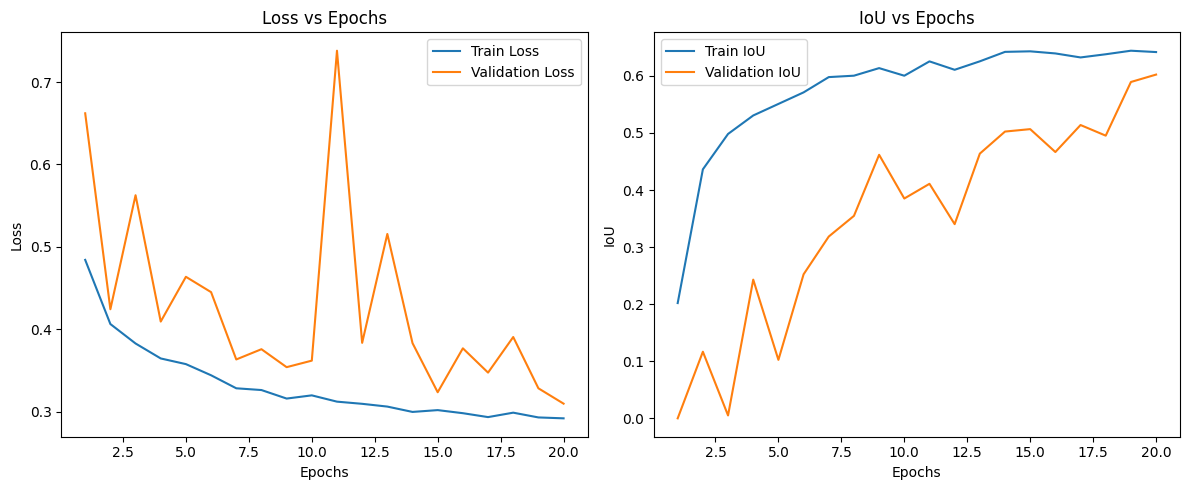

In [ ]:
plot_metrics(train_losses, val_losses, train_ious, val_ious)

In [ ]:
test_unet(model, test_loader, criterion, 0.5)
# Тестируем модель на тестовых данных с порогом 0.5 для бинаризации

Testing: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]

Test Loss: 0.3143
Average IoU: 0.5696


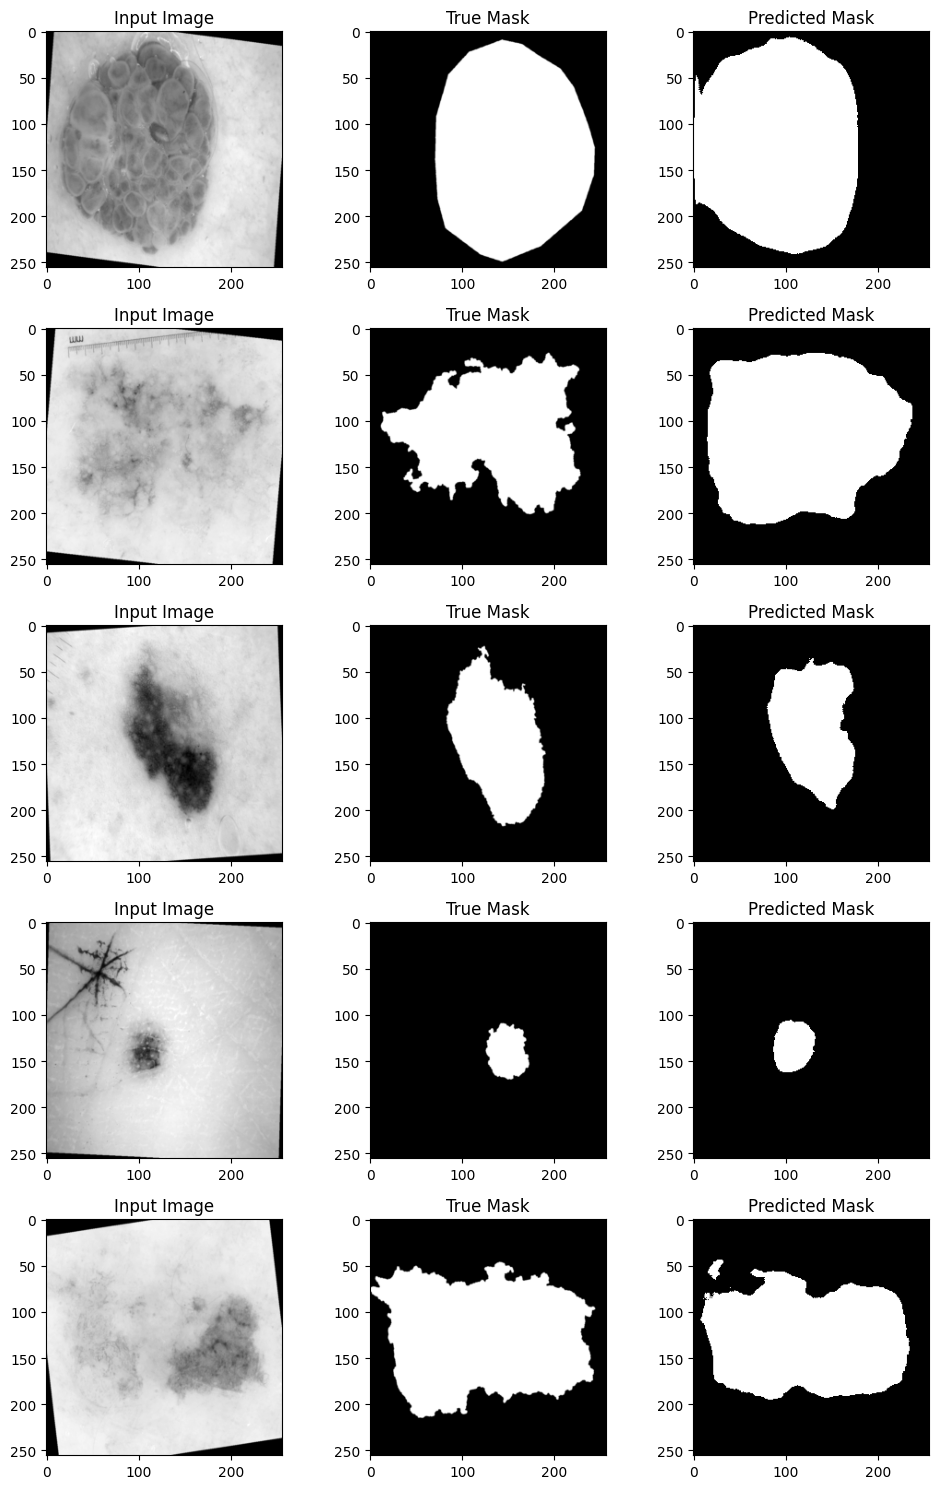

In [ ]:
visualize_predictions(model, test_loader)
# Визуализируем несколько примеров: входное изображение, настоящая маска и предсказание модели


# Вывод

Модель UNet показала низкую IoU=0.3372 метрику. Это связано с тем, что на изображениях присутствуют артефакты от монокля врача. Необходимо составить алгоритм их автоматической обрезки или применить простейший алгоритм детекции родинок, а потом уже сегментации.